In [35]:
from __future__ import division
import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Conv2DTranspose, Activation, Reshape, LayerNormalization, BatchNormalization
from tensorflow.keras.layers import Input, Dropout, Concatenate, Dense, LeakyReLU, Flatten
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [36]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    print(gpus)
    for gpu in gpus:
        print(gpu)
        tf.config.experimental.set_memory_growth(gpu, True)
    print("gpu")
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print("no gpus")
    print(e)

[]


In [37]:
MODEL_NAME = 'DCGAN'
DATA_BASE_DIR = './images/'
OUTPUT_PATH = os.path.join('outputs', MODEL_NAME)
TRAIN_LOGDIR = os.path.join("logs", "tensorflow", MODEL_NAME, 'train_data') # Sets up a log directory.
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    
TARGET_IMG_SIZE = 64 # Scale images to this size

BATCH_SIZE = 24
NOISE_DIM = 100
LAMBDA = 10 # For gradient penalty

EPOCHs = 5000
CURRENT_EPOCH = 1 # Epoch start from
SAVE_EVERY_N_EPOCH = 15 # Save checkpoint at every n epoch

N_CRITIC = 3 # Train critic(discriminator) n times then train generator 1 time.
LR = 1e-4
MIN_LR = 0.000001 # Minimum value of learning rate
DECAY_FACTOR=1.00004 # learning rate decay factor

# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)

In [38]:
# Modify the directory to the path of your dataset
list_ds = tf.data.Dataset.list_files(DATA_BASE_DIR + '*')
for f in list_ds.take(5):
    print(f.numpy())

b'./images/magnemite.png'
b'./images/terrakion.png'
b'./images/tsareena.png'
b'./images/torracat.png'
b'./images/psyduck.png'


In [39]:
def normalize(image):
    '''
        normalizing the images to [-1, 1]
    '''
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image

def preprocess_image(file_path):
    images = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    images = tf.image.decode_jpeg(images, channels=3)
    images = tf.image.resize_with_crop_or_pad(images, TARGET_IMG_SIZE, TARGET_IMG_SIZE)
    images = normalize(images)
    return images

In [40]:
train_data = list_ds.map(preprocess_image).shuffle(1000).batch(BATCH_SIZE)

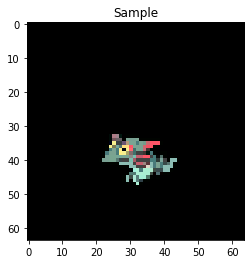

In [41]:
sample_img = next(iter(train_data))
plt.title('Sample')
plt.imshow(np.clip(sample_img[0] * 0.5 + 0.5, 0, 1))

In [42]:
def CGAN_generator(input_z_shape=NOISE_DIM):
    '''
        DCGAN like generator architecture
    '''
    input_z_layer = Input(input_z_shape)
    
    z = Dense(4*4*512, use_bias=False)(input_z_layer)
    z =Reshape((4, 4, 512))(z)
    
    x = Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(z)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    output = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation="tanh",
                             kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    model = Model(inputs=input_z_layer, outputs=output)
    return model

In [43]:
generator = CGAN_generator()
generator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_2 (Dense)             (None, 8192)              819200    
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 4, 4, 512)        4194304   
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4, 4, 512)         0   

In [44]:
def CGAN_discriminator(input_x_shape=(TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3)):
    '''
        DCGAN like discriminator architecture
    '''
    input_x_layer = Input(input_x_shape)
    
    x = Conv2D(120, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(input_x_layer)
    #x = LayerNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    #x = LayerNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    #x = LayerNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    #x = LayerNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(1, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    x = Flatten()(x)
    
    output = Dense(1)(x)
    
    model = Model(inputs=input_x_layer, outputs=output)
    return model

In [45]:
discriminator = CGAN_discriminator()
discriminator.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 120)       5760      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 32, 32, 120)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       245760    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 256)         524288    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 8, 8, 256)         0   

In [46]:
# Optimizers 
D_optimizer = Adam(learning_rate=LR, beta_1=0.5)
G_optimizer = Adam(learning_rate=LR, beta_1=0.5)

def learning_rate_decay(current_lr, decay_factor=DECAY_FACTOR):
    '''
        Calculate new learning rate using decay factor
    '''
    new_lr = max(current_lr / decay_factor, MIN_LR)
    return new_lr

def set_learning_rate(new_lr):
    '''
        Set new learning rate to optimizers
    '''
    K.set_value(D_optimizer.lr, new_lr)
    K.set_value(G_optimizer.lr, new_lr)

In [47]:
checkpoint_path = os.path.join("checkpoints", "tensorflow", MODEL_NAME)

ckpt = tf.train.Checkpoint(generator=generator,
                           discriminator=discriminator,
                           G_optimizer=G_optimizer,
                           D_optimizer=D_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    print("ther is a checkpoint")
    ckpt.restore(ckpt_manager.latest_checkpoint)
    latest_epoch = int(ckpt_manager.latest_checkpoint.split('-')[1])
    CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCH
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

ther is a checkpoint
Latest checkpoint of epoch 540 restored!!


In [48]:
def generate_and_save_images(model, epoch, test_input, figure_size=(12,6), subplot=(3,6), save=True, is_flatten=False):
    '''
        Generate images and plot it.
    '''
    predictions = model.predict(test_input)
    if is_flatten:
        predictions = predictions.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3).astype('float32')
    fig = plt.figure(figsize=figure_size)
    for i in range(predictions.shape[0]):
        axs = plt.subplot(subplot[0], subplot[1], i+1)
        plt.imshow(predictions[i] * 0.5 + 0.5)
        plt.axis('off')
    if save:
        plt.savefig(os.path.join(OUTPUT_PATH, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

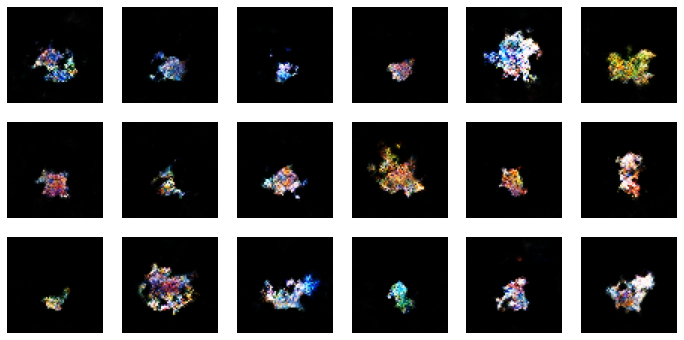

In [49]:
num_examples_to_generate = 18

# We will reuse this seed overtime
sample_noise = tf.random.normal([num_examples_to_generate, NOISE_DIM])
generate_and_save_images(generator, 0, [sample_noise], figure_size=(12,6), subplot=(3,6), save=False, is_flatten=False)

In [50]:
@tf.function
def WGAN_GP_train_d_step(real_image, batch_size, step):
    '''
        One discriminator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    epsilon = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0, maxval=1)
    ###################################
    # Train D
    ###################################
    with tf.GradientTape(persistent=True) as d_tape:
        with tf.GradientTape() as gp_tape:
            fake_image = generator([noise], training=True)
            fake_image_mixed = epsilon * tf.dtypes.cast(real_image, tf.float32) + ((1 - epsilon) * fake_image)
            fake_mixed_pred = discriminator([fake_image_mixed], training=True)
            
        # Compute gradient penalty
        grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
        grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))
        
        fake_pred = discriminator([fake_image], training=True)
        real_pred = discriminator([real_image], training=True)
        
        D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty
    # Calculate the gradients for discriminator
    D_gradients = d_tape.gradient(D_loss,
                                            discriminator.trainable_variables)
    # Apply the gradients to the optimizer
    D_optimizer.apply_gradients(zip(D_gradients,
                                                discriminator.trainable_variables))
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('D_loss', tf.reduce_mean(D_loss), step=step)

@tf.function
def WGAN_GP_train_g_step(real_image, batch_size, step):
    '''
        One generator training step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    ###################################
    # Train G
    ###################################
    with tf.GradientTape() as g_tape:
        fake_image = generator([noise], training=True)
        fake_pred = discriminator([fake_image], training=True)
        G_loss = -tf.reduce_mean(fake_pred)
    # Calculate the gradients for generator
    G_gradients = g_tape.gradient(G_loss,
                                            generator.trainable_variables)
    # Apply the gradients to the optimizer
    G_optimizer.apply_gradients(zip(G_gradients,
                                                generator.trainable_variables))
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('G_loss', G_loss, step=step)

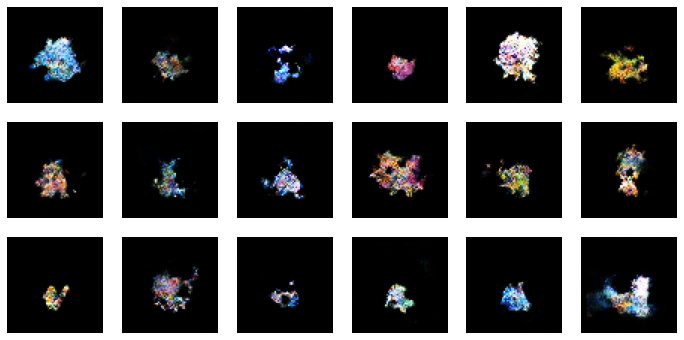

Time taken for epoch 816 is 38.88253307342529 sec

Start of epoch 817
current_learning_rate 0.000099
.

KeyboardInterrupt: 

In [51]:
current_learning_rate = LR
trace = True
n_critic_count = 0

for epoch in range(CURRENT_EPOCH, EPOCHs + 1):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    # Using learning rate decay
    current_learning_rate = learning_rate_decay(current_learning_rate)
    print('current_learning_rate %f' % (current_learning_rate,))
    set_learning_rate(current_learning_rate)
    
    for step, (image) in enumerate(train_data):
        current_batch_size = image.shape[0]
        # Train critic (discriminator)
        WGAN_GP_train_d_step(image, batch_size=tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
        n_critic_count += 1
        if n_critic_count >= N_CRITIC: 
            # Train generator
            WGAN_GP_train_g_step(image, batch_size= tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
            n_critic_count = 0
        
        if step % 10 == 0:
            print ('.', end='')
    
    # Clear jupyter notebook cell output
    clear_output(wait=True)
    # Using a consistent sample so that the progress of the model is clearly visible.
    generate_and_save_images(generator, epoch, [sample_noise], figure_size=(12,6), subplot=(3,6), save=True, is_flatten=False)
    
    if epoch % SAVE_EVERY_N_EPOCH == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             ckpt_save_path))
    
    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))
    
# Save at final epoch
ckpt_save_path = ckpt_manager.save()
print ('Saving checkpoint for epoch {} at {}'.format(EPOCHs,
                                                        ckpt_save_path))